In [1]:
# Analysis of Imbalance Ratio Effects on Loss Landscape and Overfitting

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Optional
from dataclasses import dataclass
import pandas as pd
import seaborn as sns
from tqdm import tqdm



In [2]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)



In [3]:


@dataclass
class DatasetConfig:
    """Configuration for dataset generation."""
    num_freq_samples: int = 10000  # Number of samples in the frequent bin
    imbalance_ratio: float = 10.0  # Ratio of frequent to rare samples
    radius_freq: float = 0.5  # Radius for frequent samples
    radius_rare: float = 0.8  # Radius for rare samples
    radius_width: float = 0.1  # Width of the radius band

class ImbalancedCircleDataset:
    """
    Generates a simple 2D regression dataset with imbalanced frequency bins.
    - Features: (x, y) coordinates
    - Target: Distance from origin (center)
    - Two bins: frequent (inner circle) and rare (outer circle)
    """
    
    def __init__(self, config: DatasetConfig):
        """
        Initialize the dataset generator.
        
        Args:
            config: Configuration parameters for the dataset
        """
        self.config = config
        self._generate_base_dataset()
    
    def _generate_base_dataset(self) -> None:
        """
        Generate the base dataset with frequent and rare samples.
        This is called once during initialization to maintain consistency.
        """
        # Create the frequent samples (inner circle)
        num_freq = self.config.num_freq_samples
        theta_freq = np.linspace(0, 2*np.pi, num_freq, endpoint=False)
        
        # Add small jitter to radius but keep it within the band
        r_freq = self.config.radius_freq + np.random.uniform(
            0, self.config.radius_width, num_freq)
        
        x_freq = r_freq * np.cos(theta_freq)
        y_freq = r_freq * np.sin(theta_freq)
        
        # Create many potential rare samples (outer circle)
        # We'll select from these based on the imbalance ratio
        num_potential_rare = 10000  # Large enough to support up to 10000:1 ratio
        theta_rare = np.linspace(0, 2*np.pi, num_potential_rare, endpoint=False)
        
        r_rare = self.config.radius_rare + np.random.uniform(
            0, self.config.radius_width, num_potential_rare)
        
        x_rare = r_rare * np.cos(theta_rare)
        y_rare = r_rare * np.sin(theta_rare)
        
        # Store all potential samples
        self.x_freq, self.y_freq = x_freq, y_freq
        self.r_freq = r_freq
        self.x_rare_all, self.y_rare_all = x_rare, y_rare
        self.r_rare_all = r_rare
    
    def get_dataset(self, imbalance_ratio: Optional[float] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Get dataset with specified imbalance ratio.
        
        Args:
            imbalance_ratio: Override the default imbalance ratio if provided
        
        Returns:
            Tuple of (features, targets) where features has shape (n_samples, 2)
            and targets has shape (n_samples,)
        """
        if imbalance_ratio is None:
            imbalance_ratio = self.config.imbalance_ratio
        
        # Calculate how many rare samples to include
        num_freq = len(self.x_freq)
        num_rare = int(num_freq / imbalance_ratio)
        num_rare = max(1, min(num_rare, len(self.x_rare_all)))  # Ensure valid range
        
        # Select rare samples (deterministically)
        indices = np.linspace(0, len(self.x_rare_all)-1, num_rare, dtype=int)
        x_rare = self.x_rare_all[indices]
        y_rare = self.y_rare_all[indices]
        r_rare = self.r_rare_all[indices]
        
        # Combine frequent and rare samples
        X = np.column_stack([
            np.concatenate([self.x_freq, x_rare]),
            np.concatenate([self.y_freq, y_rare])
        ])
        
        # Target is the distance from origin
        y = np.concatenate([self.r_freq, r_rare])
        
        # Create masks for visualization
        self.freq_mask = np.concatenate([np.ones(num_freq, dtype=bool), 
                                        np.zeros(num_rare, dtype=bool)])
        self.rare_mask = ~self.freq_mask
        
        return X, y
    
    def train_val_split(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        val_ratio: float = 0.2
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Split dataset into training and validation sets.
        Ensures both frequent and rare samples are represented in both sets.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            val_ratio: Fraction of data to use for validation
            
        Returns:
            X_train, X_val, y_train, y_val
        """
        # Split frequent samples
        num_freq = np.sum(self.freq_mask)
        num_freq_val = int(num_freq * val_ratio)
        freq_val_indices = np.linspace(0, num_freq-1, num_freq_val, dtype=int)
        freq_train_mask = np.ones(num_freq, dtype=bool)
        freq_train_mask[freq_val_indices] = False
        
        # Split rare samples
        num_rare = np.sum(self.rare_mask)
        num_rare_val = int(num_rare * val_ratio)
        rare_indices = np.where(self.rare_mask)[0] - num_freq  # Adjust index offset
        rare_val_indices = np.linspace(0, num_rare-1, num_rare_val, dtype=int)
        rare_val_indices = rare_indices[rare_val_indices]
        
        # Create combined masks
        train_mask = np.ones(len(X), dtype=bool)
        train_mask[freq_val_indices] = False
        train_mask[num_freq + rare_val_indices] = False
        val_mask = ~train_mask
        
        # Apply masks
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]
        
        return X_train, X_val, y_train, y_val
    
    def plot_dataset(self, X: np.ndarray, y: np.ndarray, title: str = "Dataset Visualization") -> None:
        """
        Plot the dataset showing frequent and rare samples.
        
        Args:
            X: Feature array of shape (n_samples, 2)
            y: Target array of shape (n_samples,)
            title: Plot title
        """
        plt.figure(figsize=(10, 8))
        
        # Plot frequent samples
        plt.scatter(X[self.freq_mask, 0], X[self.freq_mask, 1], 
                   c=y[self.freq_mask], cmap='Blues', s=50, alpha=0.8,
                   label=f'Frequent ({np.sum(self.freq_mask)} samples)')
        
        # Plot rare samples
        plt.scatter(X[self.rare_mask, 0], X[self.rare_mask, 1], 
                   c=y[self.rare_mask], cmap='Reds', s=80, alpha=0.8, marker='x',
                   label=f'Rare ({np.sum(self.rare_mask)} samples)')
        
        plt.colorbar(label='Distance from center (target)')
        plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        plt.title(title)
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.legend()
        plt.axis('equal')
        plt.grid(alpha=0.3)
        plt.show()



In [4]:


def create_simple_model() -> tf.keras.Model:
    """
    Create a very simple neural network with only 2 parameters.
    
    Returns:
        A TensorFlow model with 2 trainable parameters
    """
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,)),
        tf.keras.layers.Dense(
            1, 
            use_bias=True, 
            activation=None, 
            kernel_initializer='zeros', 
            bias_initializer='zeros'
        )
    ])
    
    # Verify we have exactly 2 parameters (1 weight + 1 bias)
    assert len(model.trainable_variables) == 2
    assert model.trainable_variables[0].shape == (2, 1)  # weights
    assert model.trainable_variables[1].shape == (1,)    # bias
    
    return model



In [5]:


def train_model(
    model: tf.keras.Model, 
    X_train: np.ndarray, y_train: np.ndarray,
    X_val: np.ndarray, y_val: np.ndarray,
    epochs: int = 200, 
    batch_size: int = 32
) -> Dict[str, List[float]]:
    """
    Train the model and track history.
    
    Args:
        model: TensorFlow model to train
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of training epochs
        batch_size: Batch size for training
        
    Returns:
        Dictionary with training history
    """
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss='mse'
    )
    
    # Manual training to track parameters
    train_losses = []
    val_losses = []
    param_history = []
    
    # Convert to tensors
    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
    y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Shuffle training data
        indices = tf.random.shuffle(tf.range(len(X_train)))
        X_shuffled = tf.gather(X_train_tf, indices)
        y_shuffled = tf.gather(y_train_tf, indices)
        
        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            with tf.GradientTape() as tape:
                y_pred = model(X_batch, training=True)
                loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_batch, -1)))
                
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Evaluate on full datasets
        y_train_pred = model(X_train_tf, training=False)
        train_loss = tf.reduce_mean(tf.square(y_train_pred - tf.expand_dims(y_train_tf, -1)))
        
        y_val_pred = model(X_val_tf, training=False)
        val_loss = tf.reduce_mean(tf.square(y_val_pred - tf.expand_dims(y_val_tf, -1)))
        
        # Save history
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))
        
        # Save parameter values
        w = model.trainable_variables[0].numpy().flatten()
        b = model.trainable_variables[1].numpy().flatten()
        param_history.append(np.concatenate([w, b]))
    
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'params': np.array(param_history)
    }
    
    return history



In [12]:


def compute_loss_landscape(
    model: tf.keras.Model, 
    X: np.ndarray, y: np.ndarray,
    w_range: Tuple[float, float] = (-2, 2),
    b_range: Tuple[float, float] = (-2, 2),
    resolution: int = 50
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute the loss landscape by varying the two model parameters.
    
    Args:
        model: TensorFlow model with 2 parameters
        X, y: Dataset to compute loss on
        w_range: Range for weight parameter
        b_range: Range for bias parameter
        resolution: Grid resolution for the landscape
        
    Returns:
        Grid of parameter values and corresponding losses
    """
    # Create parameter grid
    w_vals = np.linspace(w_range[0], w_range[1], resolution)
    b_vals = np.linspace(b_range[0], b_range[1], resolution)
    W, B = np.meshgrid(w_vals, b_vals)
    
    # Original parameters
    original_w = model.trainable_variables[0].numpy().copy()
    original_b = model.trainable_variables[1].numpy().copy()
    
    # Convert data to tensors
    X_tf = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
    
    # Compute loss for each parameter combination
    Z = np.zeros_like(W)
    for i in range(resolution):
        for j in range(resolution):
            # Set model parameters
            w = W[i, j]
            b = B[i, j]
            model.trainable_variables[0].assign([[w], [0.0]])  # Only vary the first weight
            model.trainable_variables[1].assign([b])
            
            # Compute loss
            y_pred = model(X_tf, training=False)
            loss = tf.reduce_mean(tf.square(y_pred - tf.expand_dims(y_tf, -1)))
            Z[i, j] = loss.numpy()
    
    # Restore original parameters
    model.trainable_variables[0].assign(original_w)
    model.trainable_variables[1].assign(original_b)
    
    return W, B, Z

def plot_loss_landscape(
    W: np.ndarray, 
    B: np.ndarray, 
    Z: np.ndarray, 
    param_history: Optional[np.ndarray] = None,
    title: str = "Loss Landscape") -> None:
    """
    Plot the loss landscape with optional training trajectory.
    
    Args:
        W, B: Parameter grid
        Z: Loss values at each point in the grid
        param_history: Optional trajectory of parameters during training
        title: Plot title
    """
    # Create a figure with 2 subplots (2D and 3D)
    fig = plt.figure(figsize=(10, 8))
    
    # 2D contour plot
    ax1 = fig.add_subplot(1, 2, 1)
    
    # Plot loss landscape as contour
    contour = ax1.contourf(W, B, Z, 50, cmap='viridis')
    plt.colorbar(contour, ax=ax1, label='Loss (MSE)')
    
    # Add contour lines
    contour_lines = ax1.contour(W, B, Z, 15, colors='white', alpha=0.5, linewidths=0.5)
    ax1.clabel(contour_lines, inline=True, fontsize=8, fmt='%.2f')
    
    # Plot optimization trajectory if provided
    if param_history is not None:
        ax1.plot(param_history[:, 0], param_history[:, 2], 'r-', linewidth=2, alpha=0.7)
        ax1.scatter(param_history[0, 0], param_history[0, 2], c='blue', s=100, 
                  label='Start', zorder=10)
        ax1.scatter(param_history[-1, 0], param_history[-1, 2], c='red', s=100, 
                  label='End', zorder=10)
    
    ax1.set_title(f"2D {title}")
    ax1.set_xlabel('Weight (w)')
    ax1.set_ylabel('Bias (b)')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # 3D surface plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surface = ax2.plot_surface(W, B, Z, cmap='viridis', alpha=0.8, 
                              rstride=1, cstride=1, linewidth=0, antialiased=True)
    
    # Plot optimization trajectory in 3D if provided
    if param_history is not None:
        # Get Z values for the trajectory points by interpolating
        from scipy.interpolate import interpn
        points = (np.linspace(W.min(), W.max(), W.shape[0]), 
                 np.linspace(B.min(), B.max(), B.shape[0]))
        trajectory_z = interpn(points, Z, 
                              param_history[:, [0, 2]], 
                              method='linear', 
                              bounds_error=False, 
                              fill_value=None)
        
        ax2.plot(param_history[:, 0], param_history[:, 2], trajectory_z, 
                'r-', linewidth=2, alpha=0.7)
        ax2.scatter(param_history[0, 0], param_history[0, 2], trajectory_z[0], 
                   c='blue', s=100, zorder=10)
        ax2.scatter(param_history[-1, 0], param_history[-1, 2], trajectory_z[-1], 
                   c='red', s=100, zorder=10)
    
    ax2.set_title(f"3D {title}")
    ax2.set_xlabel('Weight (w)')
    ax2.set_ylabel('Bias (b)')
    ax2.set_zlabel('Loss (MSE)')
    
    plt.tight_layout()
    plt.show()

def plot_training_curves(history: Dict[str, List[float]], title: str = "Training and Validation Loss") -> None:
    """
    Plot training and validation loss curves.
    
    Args:
        history: Training history dictionary
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.show()

    


In [7]:

def analyze_imbalance_effects(
    imbalance_ratios: List[float], 
    dataset_config: DatasetConfig,
    epochs: int = 200
) -> Dict:
    """
    Analyze the effects of different imbalance ratios on model training.
    
    Args:
        imbalance_ratios: List of imbalance ratios to test
        dataset_config: Configuration for dataset generation
        epochs: Number of training epochs
        
    Returns:
        Dictionary with analysis results
    """
    results = {
        'imbalance_ratios': imbalance_ratios,
        'final_train_loss': [],
        'final_val_loss': [],
        'min_train_loss': [],
        'min_val_loss': [],
        'overfit_degree': [],  # Difference between train and val loss
        'loss_landscapes': []
    }
    
    # Generate base dataset
    dataset = ImbalancedCircleDataset(dataset_config)
    
    for ratio in tqdm(imbalance_ratios, desc="Testing imbalance ratios"):
        # Get dataset with current imbalance ratio
        X, y = dataset.get_dataset(imbalance_ratio=ratio)
        X_train, X_val, y_train, y_val = dataset.train_val_split(X, y)
        
        # Create and train model
        model = create_simple_model()
        history = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
        # Compute loss landscape
        W, B, Z = compute_loss_landscape(model, X, y)
        
        # Store results
        results['final_train_loss'].append(history['train_loss'][-1])
        results['final_val_loss'].append(history['val_loss'][-1])
        results['min_train_loss'].append(min(history['train_loss']))
        results['min_val_loss'].append(min(history['val_loss']))
        results['overfit_degree'].append(history['val_loss'][-1] - history['train_loss'][-1])
        results['loss_landscapes'].append((W, B, Z, history))
    
    return results



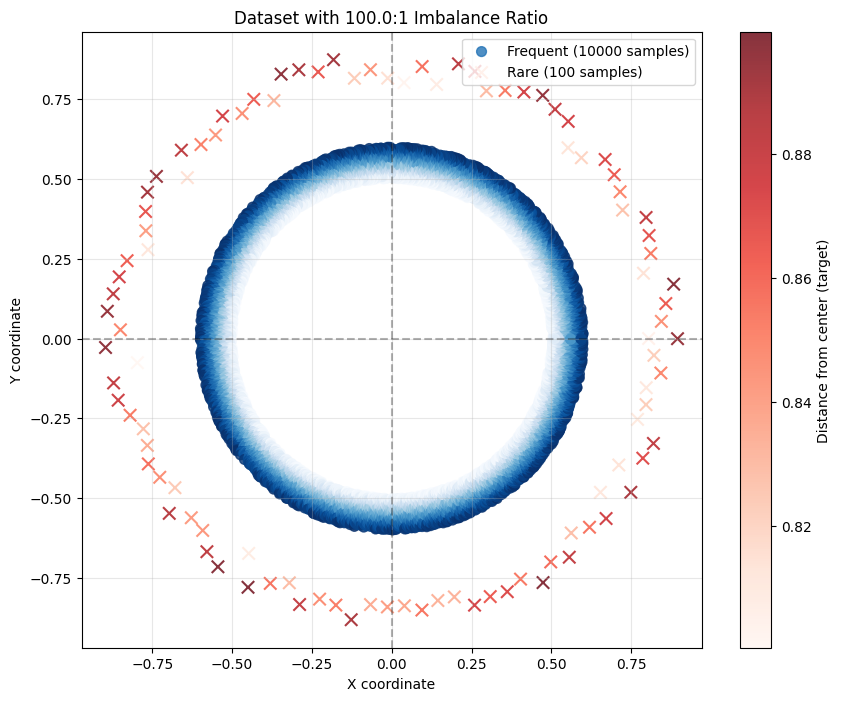

100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


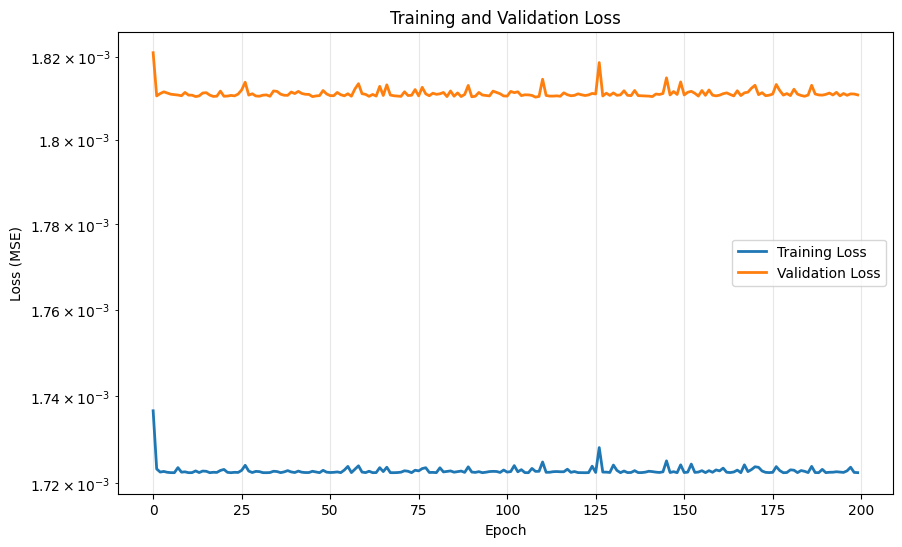

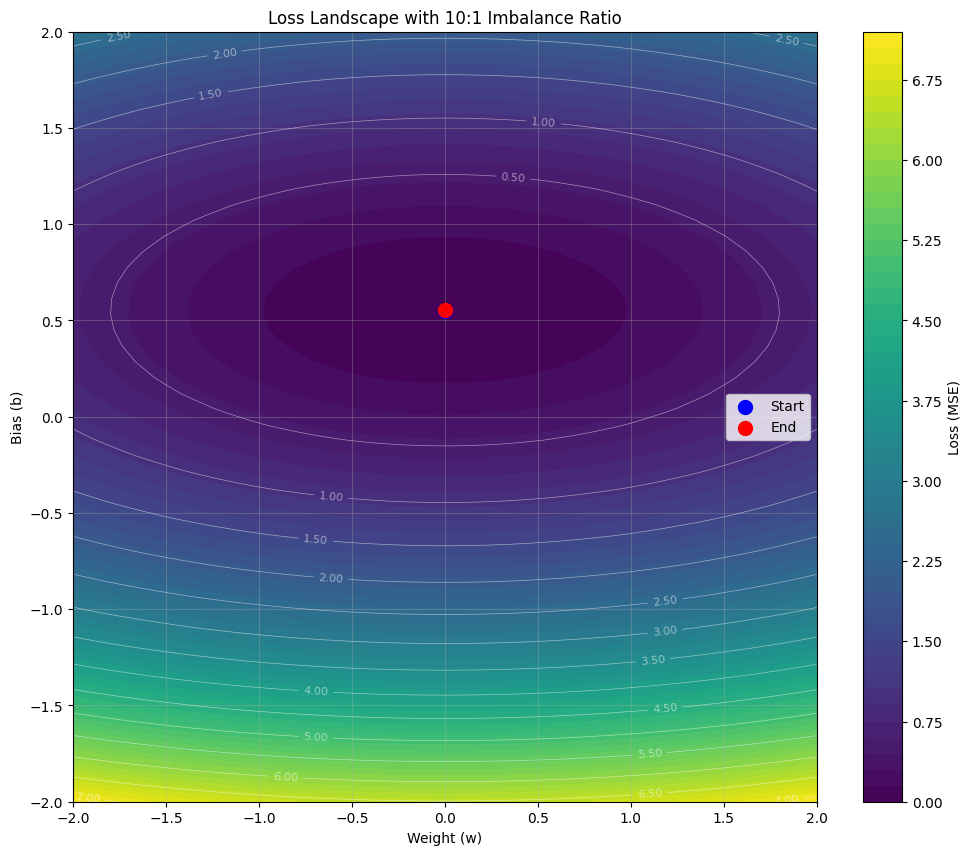

In [10]:

# Configuration
config = DatasetConfig(
    num_freq_samples=10000,
    imbalance_ratio=1.0,
    radius_freq=0.5,
    radius_rare=0.8,
    radius_width=0.1
)

# Generate dataset
dataset = ImbalancedCircleDataset(config)

imb_ratio = 100.0

# Test with a single imbalance ratio
X, y = dataset.get_dataset(imbalance_ratio=imb_ratio)
dataset.plot_dataset(X, y, title=f"Dataset with {imb_ratio}:1 Imbalance Ratio")

# Train model
X_train, X_val, y_train, y_val = dataset.train_val_split(X, y)
model = create_simple_model()
history = train_model(model, X_train, y_train, X_val, y_val, epochs=20)

# Plot results
plot_training_curves(history)

# Compute and plot loss landscape
W, B, Z = compute_loss_landscape(model, X, y)
plot_loss_landscape(W, B, Z, history['params'], title="Loss Landscape with 10:1 Imbalance Ratio")



In [ ]:


# Analyze multiple imbalance ratios
imbalance_ratios = [1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0, 10000.0]
results = analyze_imbalance_effects(imbalance_ratios, config)

# Plot comparison of results
plt.figure(figsize=(12, 8))
plt.plot(imbalance_ratios, results['final_train_loss'], 'b-', label='Final Train Loss')
plt.plot(imbalance_ratios, results['final_val_loss'], 'r-', label='Final Val Loss')
plt.plot(imbalance_ratios, results['overfit_degree'], 'g-', label='Overfitting Degree')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Imbalance Ratio (log scale)')
plt.ylabel('Loss (MSE, log scale)')
plt.title('Effect of Imbalance Ratio on Model Performance')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()

# Display selected loss landscapes
for i, ratio in enumerate([1.0, 100.0, 10000.0]):
    idx = imbalance_ratios.index(ratio)
    W, B, Z, hist = results['loss_landscapes'][idx]
    plot_loss_landscape(W, B, Z, hist['params'], 
                        title=f"Loss Landscape with {ratio}:1 Imbalance Ratio")
    plot_training_curves(hist, title=f"Training Curves with {ratio}:1 Imbalance Ratio")